In [31]:
!nvidia-smi

Sat Aug 16 16:54:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P0             27W /   70W |    4474MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [32]:
pip install opendatasets

In [33]:
import opendatasets as od

od.download(
    "https://www.kaggle.com/datasets/apollo2506/eurosat-dataset")

Skipping, found downloaded files in "./eurosat-dataset" (use force=True to force download)


In [34]:
import os
import shutil

# Path to dataset after download
dataset_path = "/content/eurosat-dataset/EuroSAT"

# Classes to keep
keep_classes = ["Forest", "SeaLake", "Residential"]

# Where to store filtered dataset
filtered_path = "eurosat_filtered"

# Remove existing filtered folder if it exists
if os.path.exists(filtered_path):
    shutil.rmtree(filtered_path)

os.makedirs(filtered_path, exist_ok=True)

# Copy only selected classes
for cls in keep_classes:
    src = os.path.join(dataset_path, cls)
    dst = os.path.join(filtered_path, cls)
    shutil.copytree(src, dst)

print("Filtered dataset saved to:", filtered_path)


Filtered dataset saved to: eurosat_filtered


In [35]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
import requests
import tempfile
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [36]:
import os
import pandas as pd

# Create an empty dataframe
data = pd.DataFrame(columns=['image_path', 'label'])

# Define the folder paths and corresponding labels
labels = {
    r"/content/eurosat-dataset/EuroSAT/Forest": "Forest",
    r"/content/eurosat-dataset/EuroSAT/Residential": "Residential",
    r"/content/eurosat-dataset/EuroSAT/SeaLake": "SeaLake",
}

# Validate folder paths
for folder, label in labels.items():
    if not os.path.exists(folder):
        print(f"Warning: The folder {folder} does not exist.")
        continue

    # Process each image in the folder
    for image_name in os.listdir(folder):
        image_path = os.path.join(folder, image_name)
        if os.path.isfile(image_path):  # Only process files
            data = pd.concat([data, pd.DataFrame({'image_path': [image_path], 'label': [label]})], ignore_index=True)

# Display the resulting DataFrame
print(data)

                                             image_path    label
0     /content/eurosat-dataset/EuroSAT/Forest/Forest...   Forest
1     /content/eurosat-dataset/EuroSAT/Forest/Forest...   Forest
2     /content/eurosat-dataset/EuroSAT/Forest/Forest...   Forest
3     /content/eurosat-dataset/EuroSAT/Forest/Forest...   Forest
4     /content/eurosat-dataset/EuroSAT/Forest/Forest...   Forest
...                                                 ...      ...
8995  /content/eurosat-dataset/EuroSAT/SeaLake/SeaLa...  SeaLake
8996  /content/eurosat-dataset/EuroSAT/SeaLake/SeaLa...  SeaLake
8997  /content/eurosat-dataset/EuroSAT/SeaLake/SeaLa...  SeaLake
8998  /content/eurosat-dataset/EuroSAT/SeaLake/SeaLa...  SeaLake
8999  /content/eurosat-dataset/EuroSAT/SeaLake/SeaLa...  SeaLake

[9000 rows x 2 columns]


In [37]:
data.to_csv('image_dataset.csv', index=False)

In [38]:
df = pd.read_csv("image_dataset.csv")

In [39]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

In [40]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=45,
    vertical_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_path",
    y_col="label",
    target_size=(255, 255),
    batch_size=32,
    class_mode="categorical"
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="image_path",
    y_col="label",
    target_size=(255, 255),
    batch_size=32,
    class_mode="categorical"
)


Found 7200 validated image filenames belonging to 3 classes.
Found 1800 validated image filenames belonging to 3 classes.


In [41]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(255, 255, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [42]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 253, 253, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,363 (56.61 MB)

 Trainable params: 14,839,363 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
history = model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 121s 501ms/step - accuracy: 0.7528 - loss: 0.5734 - val_accuracy: 0.8817 - val_loss: 0.2506
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 111s 493ms/step - accuracy: 0.8776 - loss: 0.2773 - val_accuracy: 0.8978 - val_loss: 0.2148
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 143s 498ms/step - accuracy: 0.8945 - loss: 0.2497 - val_accuracy: 0.9056 - val_loss: 0.2064
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 142s 498ms/step - accuracy: 0.8889 - loss: 0.2582 - val_accuracy: 0.9178 - val_loss: 0.2032
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 114s 508ms/step - accuracy: 0.9117 - loss: 0.2056 - val_accuracy: 0.9222 - val_loss: 0.1434
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 111s 494ms/step - accuracy: 0.9437 - loss: 0.1431 - val_accuracy: 0.9522 - val_loss: 0.1051
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 113s 501ms/step - accuracy: 0.9703 - loss: 0.0838 - val_accuracy: 0.9661 - val_loss: 0.0863
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 141s 497ms/step - accuracy: 0.9751 -

In [44]:
num_samples = test_df.shape[0]
score = model.evaluate(test_generator, steps=num_samples//32+1)

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9801 - loss: 0.0409


In [45]:
model.save('Modelenv.v1.h5')


In [46]:
# Reload
model = load_model("Modelenv.v1.h5")


In [47]:
class_names = ['Forest', 'SeaLake', 'Residential']

In [48]:
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [49]:
predictions = model.predict(test_generator)
actual_labels = test_generator.classes
predicted_labels = np.argmax(predictions, axis=1)

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step


In [50]:
cm = confusion_matrix(actual_labels, predicted_labels)

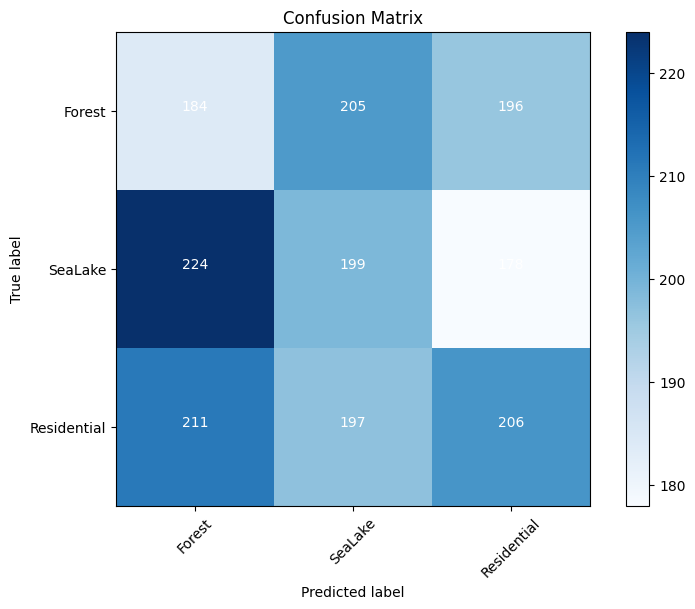

In [51]:
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, classes=class_names)
plt.show()

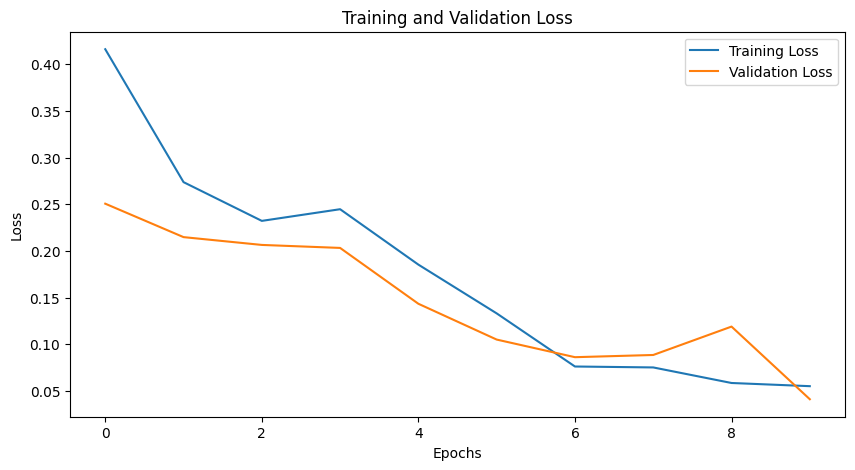

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

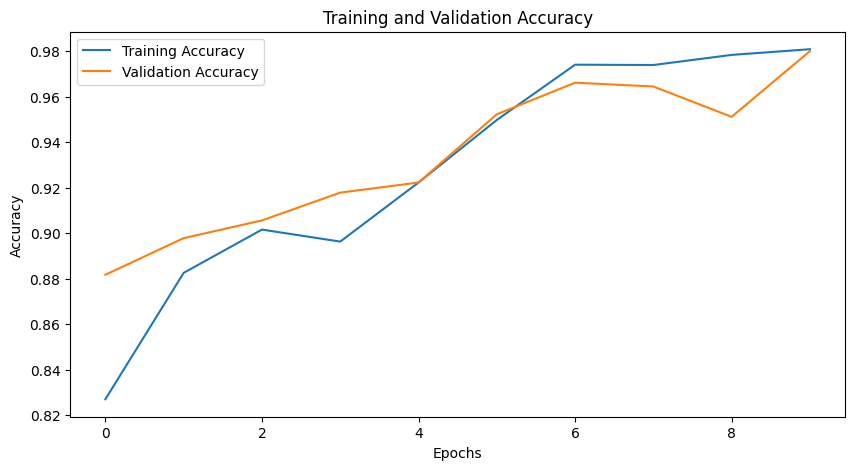

In [53]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step

Class probabilities:
Forest: 0.00%
Residential: 100.00%
SeaLake: 0.00%


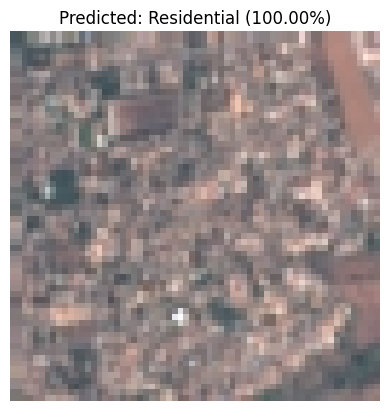

The image is predicted as: Residential


In [57]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Define class labels manually (instead of loading from JSON)
class_labels = {0: 'Forest', 1: 'Residential', 2: 'SeaLake'}

def predict_image(image_path, model_path='Modelenv.v1.h5'):
    # Load trained model
    model = load_model(model_path)

    # Load and preprocess image
    img = image.load_img(image_path, target_size=(255, 255))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Predict
    predictions = model.predict(img_array)[0]  # shape: (num_classes,)
    predicted_class = np.argmax(predictions)
    confidence = predictions[predicted_class] * 100

    # Print all probabilities
    print("\nClass probabilities:")
    for idx, prob in enumerate(predictions):
        print(f"{class_labels[idx]}: {prob*100:.2f}%")

    # Display image with prediction
    plt.imshow(image.load_img(image_path))
    plt.title(f"Predicted: {class_labels[predicted_class]} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

    return class_labels[predicted_class]

# Example usage
image_path = r"/content/eurosat_filtered/Residential/Residential_1465.jpg"
prediction = predict_image(image_path)
print(f"The image is predicted as: {prediction}")


Found 9000 images belonging to 3 classes.

Classification Report:

              precision    recall  f1-score   support

      Forest       0.96      1.00      0.98      3000
 Residential       1.00      1.00      1.00      3000
     SeaLake       1.00      0.95      0.98      3000

    accuracy                           0.98      9000
   macro avg       0.98      0.98      0.98      9000
weighted avg       0.98      0.98      0.98      9000



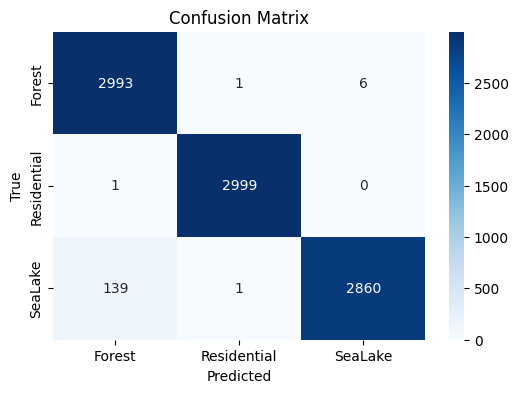

In [58]:
# Paths
dataset_path = "/content/eurosat_filtered"
model_path = "/content/Modelenv.v1.h5"

# Class mapping (make sure order matches your training)
class_labels = ['Forest', 'Residential', 'SeaLake']

# Load model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

model = load_model(model_path)

# Data generator for evaluation
datagen = ImageDataGenerator(rescale=1./255)
test_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(255, 255),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Predictions
pred_probs = model.predict(test_gen, verbose=0)
pred_labels = pred_probs.argmax(axis=1)

# Metrics
print("\nClassification Report:\n")
print(classification_report(test_gen.classes, pred_labels, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(test_gen.classes, pred_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [59]:
import shutil

# Compress the folder into a zip file
shutil.make_archive("eurosat_filtered", 'zip', "/content/eurosat_filtered")

# Download the zip
from google.colab import files
files.download("eurosat_filtered.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>